In [1]:
from ml4floods.models.config_setup import get_default_config
from ml4floods.data import save_cog, utils
import fsspec
import warnings
import sys
import traceback
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\1\Documents\Projectes\Floods\Credentials\ml4cc-general-access_request_pays.json"

In [2]:

experiment_name = "WF2_Unet_unused_from_checkpoint"
config_fp = rf'X:\home\kike\Projectes\ml4floods\2_MLModelMart\{experiment_name}\config.json'
config = get_default_config(config_fp)

from ml4floods.models.model_setup import get_model

config["model_params"]['model_folder'] = rf'X:\home\kike\Projectes\ml4floods\2_MLModelMart'
config["model_params"]['test'] = True
config["model_params"]['train'] = False
config["model_params"]["max_tile_size"] = 1024

model = get_model(config.model_params, experiment_name)

#model.eval()
#model.to("cuda:0")

from ml4floods.models.model_setup import get_model_inference_function

inference_function = get_model_inference_function(model, config,apply_normalization=True,activation="sigmoid")


Loaded Config for experiment:  WF2_Unet_unused_from_checkpoint
{   'data_params': {   'batch_size': 32,
                       'bucket_id': '',
                       'channel_configuration': 'all',
                       'download': {   'test': False,
                                       'train': False,
                                       'val': False},
                       'filter_windows': {   'apply': True,
                                             'threshold_clouds': 0.8,
                                             'version': 'v2'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': '/media/disk/databases/WORLDFLOODS/2_Mart/worldfloods_extra_v2_0',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '/home/kike/Projectes/ml4floods/splits/spli

In [69]:
import rasterio
import numpy as np
from rasterio import plot as rasterioplt
from ml4floods.visualization.plot_utils import *
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

from typing import Optional, Tuple, Union

import torch
from ml4floods.data.worldfloods.configs import BANDS_S2
def load_input(tiff_input:str, channels:List[int], window:Optional[rasterio.windows.Window]=None) -> Tuple[torch.Tensor, rasterio.transform.Affine]:
    """
    Reads from a tiff the specified channel and window.

    Args:
        tiff_input:
        window: rasterio.Window object to read (None to read all)
        channels: 0-based channels to read

    Returns:
        3-D tensor (len(channels), H, W), Affine transform to geo-reference the array read.

    """
    with utils.rasterio_open_read(tiff_input) as rst:
        inputs = rst.read((np.array(channels) + 1).tolist(), window=window)
        # Shifted transform based on the given window (used for plotting)
        transform = rst.transform if window is None else rasterio.windows.transform(window, rst.transform)
        profile = rst.profile
        torch_inputs = torch.tensor(np.nan_to_num(inputs).astype(np.float32))
    return torch_inputs, transform, profile

def gt_with_permanent_water(gt: np.ndarray, permanent_water: np.ndarray)->np.ndarray:
    """ Permanent water taken from: https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_2_YearlyHistory"""

    cloud = gt[0,:]
    gt=gt[1,:]
    gt[(gt == 2) & (permanent_water == 3)] = 4 # set as permanent_water
    gt[(gt == 2) & (permanent_water == 2)] = 5 # set as seasonal water
    gt[(gt == 2) & (permanent_water == 1)] = 4 # set as seasonal water
    gt[cloud == 2] = 3 #set as cloud
    gt[gt == 0] = 0 #invalids

    return gt

COLORS_WORLDFLOODS = np.array([[0, 0, 0], # invalid
                               [139, 64, 0], # land
                               [0, 0, 139], # water
                               [220, 220, 220]], # cloud
                              dtype=np.float32) / 255

INTERPRETATION_WORLDFLOODS = ["invalid", "land", "water", "cloud"]

COLORS_WORLDFLOODS_PERMANENT = np.array([[0, 0, 0], # 0: invalid
                                         [139, 64, 0], # 1: land
                                         [237, 0, 0], # 2: flood_water
                                         [220, 220, 220], # 3: cloud
                                         [0, 0, 139], # 4: permanent_water
                                         [60, 85, 92]], # 5: seasonal_water
                                        dtype=np.float32) / 255

INTERPRETATION_WORLDFLOODS_PERMANENT = ["invalid", "land", "flood water", "cloud", "permanent water", "seasonal water"]

def plot_inference_set(inputs_show: np.ndarray, targets: np.ndarray, 
                       predictions: np.ndarray, permanent_water: np.ndarray, transform: rasterio.Affine)->None:
    """
    Plots inputs, targets and prediction into lat/long visualisation
    
    Args:
        inputs: input Tensor
        targets: gt target Tensor
        prediction: predictions output by model (softmax, argmax already applied)
        permanent_water: permanent water raster
        transform: transform used to plot with lat/long
    """
    fig, ax = plt.subplots(2,2,figsize=(16,16))
    fig.subplots_adjust(wspace=0.01, hspace = 0.05)
    
    permanent_water = permanent_water.squeeze()
    targets_show = gt_with_permanent_water(targets, permanent_water)
    prediction_show = predictions[0,1]
    
    # Color categories {-1: invalid, 0: land, 1: water, 2: clouds}
    
    cmap_preds, norm_preds, patches_preds = get_cmap_norm_colors(COLORS_WORLDFLOODS[0:3], INTERPRETATION_WORLDFLOODS[0:3])
    cmap_gt, norm_gt, patches_gt = get_cmap_norm_colors(COLORS_WORLDFLOODS_PERMANENT, INTERPRETATION_WORLDFLOODS_PERMANENT)
    
    prediction_show += 1
    prediction_show[targets_show == 0] = 0

    rgb = np.clip(inputs_show[[3,2,1], :, :]/3000.,0,1)
    
    bands_false_composite = [BANDS_S2.index(b) for b in ["B11", "B8", "B4"]] # swir_1, nir, red composite
    false_rgb = np.clip(inputs_show[bands_false_composite, :, :]/3000.,0,1)
    

    rasterioplt.show(rgb,transform=transform,ax=ax[0,0])
    ax[0,0].set_title("RGB Composite")
    rasterioplt.show(false_rgb,transform=transform,ax=ax[0,1])
    ax[0,1].set_title("SWIR1,NIR,R Composite")
    rasterioplt.show(targets_show,transform=transform,ax=ax[1,0], cmap=cmap_gt, norm=norm_gt,
                     interpolation='nearest')
    rasterioplt.show(prediction_show, transform=transform, ax=ax[1,1],cmap=cmap_preds, norm=norm_preds,
                     interpolation='nearest')
    
    ax[1,0].set_title("Ground Truth")
    ax[1,0].legend(handles=patches_gt,
                 loc='upper right')
    
    ax[1,1].set_title("Prediction water")
    ax[1,1].legend(handles=patches_preds,
                   loc='upper right')
    ax[0,0].axis('off')
    ax[0,1].axis('off')
    ax[1,0].axis('off')
    ax[1,1].axis('off')
    


In [ ]:
from ml4floods.models.model_setup import get_channel_configuration_bands

cache_folder = None
window = None

file = 'EMSR342_06NORTHNORMANTON_DEL_v1_observed_event_a'

s2_file = rf"X:\media\disk\databases\WORLDFLOODS\2_Mart\worldfloods_extra_v2_0\test\S2\{file}.tif"
gt_file = s2_file.replace('S2','gt')
pwater_file = s2_file.replace('S2','PERMANENTWATERJRC')
channels = get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)
# Load the image and ground truth

gt= get_image_transform(gt_file)[0]
pwater = get_image_transform(pwater_file)[0]
s2_image = get_image_transform(s2_file)[0]

gt_final = gt_with_permanent_water(gt,pwater.squeeze())

torch_inputs = load_input(s2_file, channels)[0]
outputs = inference_function(torch_inputs.unsqueeze(0)) # (batch_size, num_classes, h, w)
outputs.shape

(1, 2, 5731, 5400)

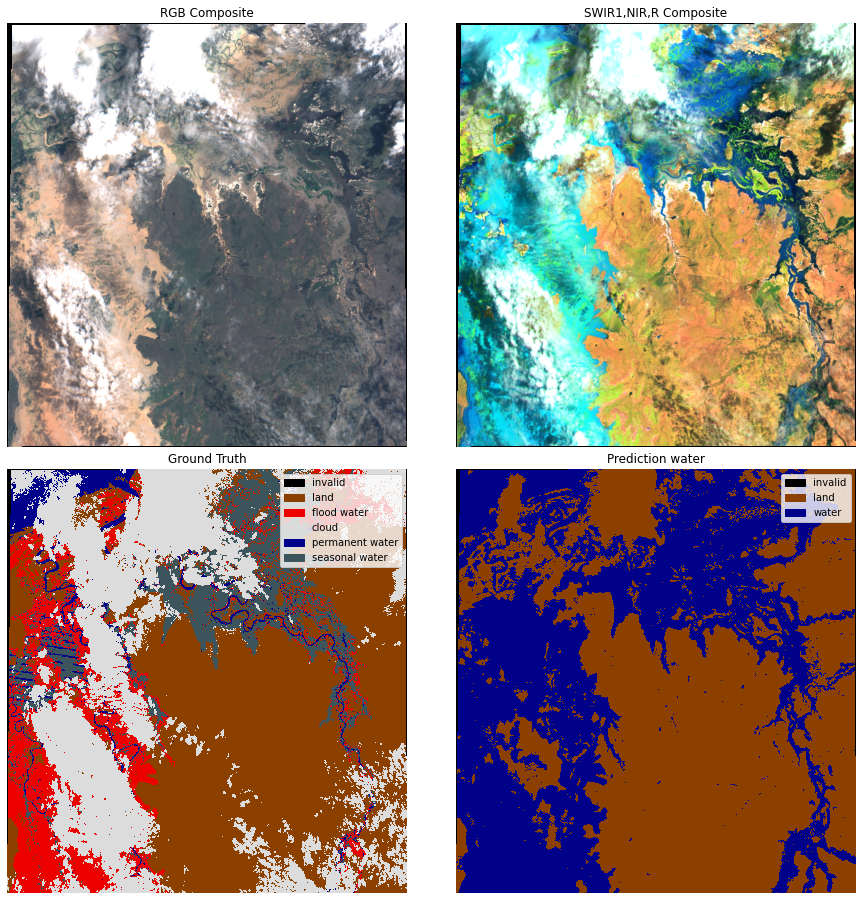

In [80]:
predictions = outputs > 0.8
predictions = (predictions).cpu().numpy().astype(float)
s2_image, transform = get_image_transform(s2_file)
plot_inference_set(s2_image, gt, predictions, pwater, transform)
predictions.shape